# Kaggle数字识别入门中文版

# 1. 数据处理
## 加载需要用到的库

In [26]:
# 数据处理库
import numpy as np
import pandas as pd
# 图表库
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sb
# 机器学习裤 （用于处理数据）
import sklearn
from sklearn.model_selection import train_test_split
# 深度学习库
import keras
import keras.layers as layers

## 读取数据

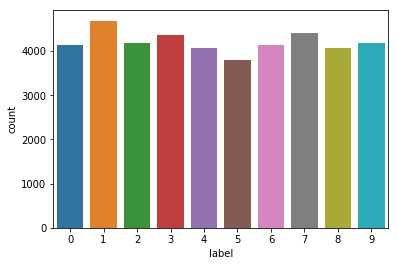

In [2]:
# 读数据
data_train = pd.read_csv('./Data/train.csv')
data_test = pd.read_csv('./Data/test.csv')

# 提取数据和标签
y_train = data_train.iloc[:,0]
X_train = data_train.iloc[:,1:]
X_test = data_test

# 画标签分布
sb.countplot(y_train)
plt.show()

## 查看空数据

In [3]:
def calc_null(data,top_n):
    total= data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print(missing_data.head(top_n))

calc_null(X_train,5)
calc_null(X_test,5)

          Total  Percent
pixel783      0      0.0
pixel268      0      0.0
pixel266      0      0.0
pixel265      0      0.0
pixel264      0      0.0
          Total  Percent
pixel783      0      0.0
pixel268      0      0.0
pixel266      0      0.0
pixel265      0      0.0
pixel264      0      0.0


### 没有空数据，不需要处理
## 归一化

In [4]:
# 归一化
X_train = X_train / 255.0
X_test = X_test / 255.0

## 将数据变形为需要的维度
### 因为输入CNN的图片数据维度应该为（N,H,W,D）

In [5]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### 将标签转换为独热码

In [6]:
y_train = keras.utils.to_categorical(y_train,num_classes=10)

## 在测试集中分出一部分作为验证集

In [7]:
seed = 2
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=seed)

# 2. 建立卷积网络CNN
## 定义模型

In [8]:
def init_model():
    reg=keras.regularizers.l2(.0)
    
    return keras.Sequential([
        layers.Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu', \
                      kernel_regularizer=reg,input_shape=(28,28,1)),
        layers.Conv2D(filters=32,kernel_size=(5,5),padding='same', \
                      activation='relu',kernel_regularizer=reg),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.25), # 输出为(N,14,14,32)
        layers.BatchNormalization(),
        layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', \
                      activation='relu',kernel_regularizer=reg),
        layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', \
                      activation='relu',kernel_regularizer=reg),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.25), # 输出为(N,7,7,64)
        layers.BatchNormalization(),
        layers.Flatten(), # 输出为(N,7*7*64) 
        layers.Dense(256, activation='relu',kernel_regularizer=reg),
        layers.Dropout(0.25), # 输出为（N,256）
        layers.BatchNormalization(),
        layers.Dense(10, activation='softmax',kernel_regularizer=reg), # 输出类别概率
    ])

model = init_model()

## 设置优化方法并编译模型

In [9]:
#optimizer = keras.optimizers.SGD(lr=0.01,momentum=0.9,decay=1e-5,nesterov=True)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
#optimizer = keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["accuracy"])

## 设置学习率衰减

In [10]:
lr_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=1e-5)

## 设置epoch数和batch大小

In [11]:
# 这两个参数，自己按机器的情况调整
epoch = 15
batch_size = 64

# 3. 数据增强

In [12]:
# 千万不要设置倒置或镜像，如6变9
data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # 随机旋转
    zoom_range = 0.1, # 随机缩放
    width_shift_range=0.1,  # 随机横向偏移
    height_shift_range=0.1,  # 随机纵向偏移
)

data_gen.fit(X_train)

# 4. 训练模型

In [13]:
history = model.fit_generator(
    data_gen.flow(X_train,y_train,batch_size=batch_size),
    epochs = epoch, validation_data=(X_val,y_val),verbose=1,
    steps_per_epoch=X_train.shape[0]//batch_size,
    callbacks=[lr_decay],
)

Epoch 1/20
590/590 [==============================] - 12s 20ms/step - loss: 0.2368 - acc: 0.9273 - val_loss: 0.2044 - val_acc: 0.9486
Epoch 2/20
590/590 [==============================] - 10s 17ms/step - loss: 0.0917 - acc: 0.9731 - val_loss: 0.0405 - val_acc: 0.9867
Epoch 3/20
590/590 [==============================] - 10s 16ms/step - loss: 0.0712 - acc: 0.9781 - val_loss: 0.0368 - val_acc: 0.9879
Epoch 4/20
590/590 [==============================] - 10s 17ms/step - loss: 0.0599 - acc: 0.9819 - val_loss: 0.0383 - val_acc: 0.9898
Epoch 5/20
590/590 [==============================] - 10s 16ms/step - loss: 0.0526 - acc: 0.9844 - val_loss: 0.0835 - val_acc: 0.9783
Epoch 6/20
590/590 [==============================] - 10s 17ms/step - loss: 0.0520 - acc: 0.9838 - val_loss: 0.0407 - val_acc: 0.9898
Epoch 7/20
590/590 [==============================] - 10s 17ms/step - loss: 0.0473 - acc: 0.9858 - val_loss: 0.0496 - val_acc: 0.9864

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00

# 5. 评估模型
## 学习曲线

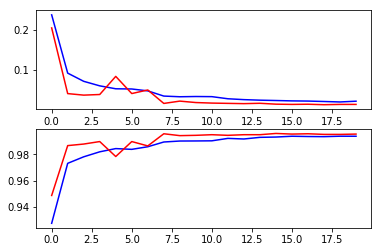

In [55]:
fig,ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'],color='b',label='Training loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation loss',axes=ax[0])

ax[1].plot(history.history['acc'],color='b',label='Training accuracy')
ax[1].plot(history.history['val_acc'],color='r',label='Validation accuracy')

plt.show()

## 误差矩阵

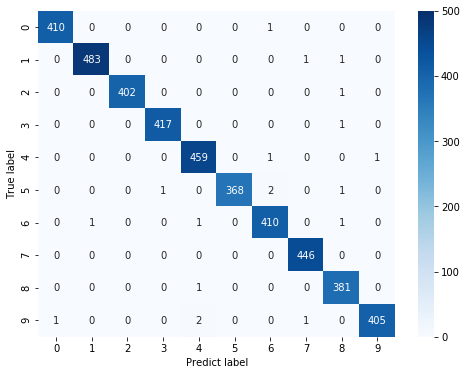

In [61]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val,axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(8,6))
ax = sb.heatmap(confusion_matrix,annot=True, fmt='d', vmin=0, vmax=500, cmap=plt.cm.Blues)
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')
plt.show()

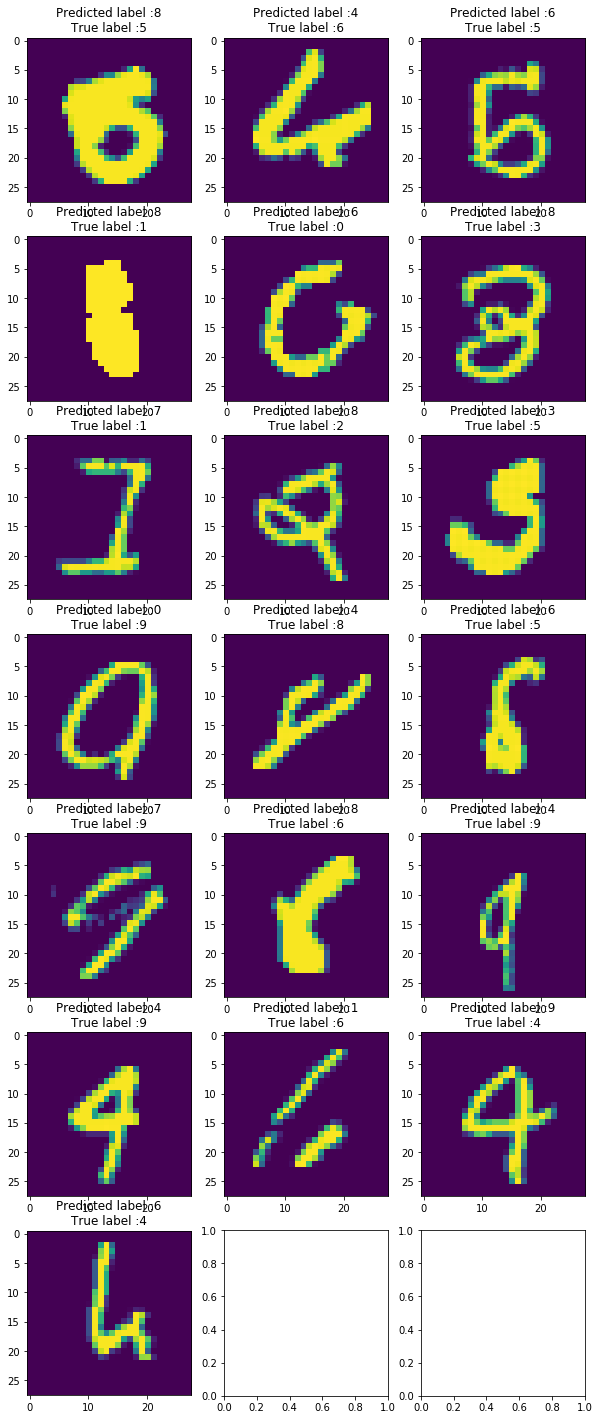

In [89]:
errors = (y_pred_classes - y_val_classes != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_val_classes_errors = y_val_classes[errors]
X_val_errors = X_val[errors]

def display_errors(img_errors, pred_errors, obs_errors):
    n = img_errors.shape[0]
    index = 0
    nCols = 3
    nRows = int(np.ceil(float(n) / nCols))
    fig, ax = plt.subplots(nRows,nCols)
    fig.set_figwidth(10)
    fig.set_figheight(25)
    for row in range(nRows):
        for col in range(nCols):
            ax[row,col].imshow((img_errors[index]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[index],obs_errors[index]))
            index+=1
            if index == n:
                break;
            
display_errors(X_val_errors, y_pred_classes_errors, y_val_classes_errors)

# 6. 最终预测并提交

In [90]:
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,results.shape[0]+1),name="ImageId"),results],axis=1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)